In [1]:
# import tensorflow as tf
# sess = tf.Session()
import keras
from keras import backend as K
# K.set_session(sess)
import h5py

from keras.models import Model
from keras.layers import Dense, LSTM, Input, Embedding, GRU, Masking, Dropout, Lambda, Flatten, concatenate, Conv1D, Activation
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, Adam
from keras.preprocessing.sequence import pad_sequences

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# import pandas 

from process_data import *
import os



Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13757668888164343066
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 11332668621
locality {
  bus_id: 1
}
incarnation: 9647691613611201275
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0"
]


In [3]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args # reorder the args because the order is shit
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [4]:
# Problem parameters
max_mfe_len = 1800
max_phrase_len = 300
n_energies = 40
n_letters = 27+1 # 26 chars, 1 space, 1 blank
blank_idx = n_letters - 1

# Model parameters
n_blocks = 3
layers_per_block = 5
n_filters = 128
kernel_size = 7
activation = "relu"

max_dilation = 2**(layers_per_block-1)
block_rf = max_dilation * (kernel_size-1) + 1 + (kernel_size-1)/2 * (layers_per_block-1)
print "block_rf =", block_rf


# Input tensors include labels, input lengths and label lengths because we define the cost tensor explicitly
log_mfes = Input(shape=(max_mfe_len, n_energies), name="log_mfes")
labels = Input(name='the_labels', shape=[max_phrase_len], dtype='float32')
labels_masked = (labels) # Should we have this?
input_length = Input(name='input_length',shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

# Simple residual block without multiplicative gates or size-1 time convolutions
def res_block(prev):
    r = prev
    # This gives an rf size of: 
    # max_dilation * (kernel_size-1) + 1 + (kernel_size-1)/2 * (layers_per_block-1)
    for x in range(layers_per_block):
        dilation_rate = 2**x
        linear = Conv1D(n_filters, 
                        kernel_size, 
                        padding='same', 
                        dilation_rate=dilation_rate, 
                        activation="linear")(r)
        batch_normed = BatchNormalization()(linear)
        a = Activation(activation)(batch_normed)
        r = concatenate([a, r])
    return r

# def super_res_block(prev):
#     r = prev
#     # This gives an rf size of: 
#     # max_dilation * (kernel_size-1) + 1 + (kernel_size-1)/2 * (layers_per_block-1)
#     for x in range(layers_per_block):
#         dilation_rate = 2**x
        
#         # gates
#         bn_gate_linear = BatchNormalization()(Conv1D(
#                         n_filters, 
#                         kernel_size, 
#                         padding='same', 
#                         dilation_rate=dilation_rate, 
#                         activation="linear")(r))
#         gate = Activation("sigmoid")(bn_gate_linear)
        
#         # filters
#         bn_filter_linear = BatchNormalization()(Conv1D(
#                         n_filters, 
#                         kernel_size, 
#                         padding='same', 
#                         dilation_rate=dilation_rate, 
#                         activation="linear")(r))
#         filt = Activation("tanh")(batch_normed)
        
#         # size-1 conv
#         bn_out_linear = BatchNormalization()(Conv1D(
#                         n_filters, 
#                         1, 
#                         padding='same', 
#                         activation="linear")(gate * filt))
#         out = Activation("tanh")(bn_out_linear)
#         r = concatenate([a, r])
        
#     return r
    

r = log_mfes
for i in range(n_blocks):
    r = res_block(r)
logits =  BatchNormalization()(Conv1D(n_letters, 
                                     kernel_size,
                                     padding='same', 
                                     dilation_rate=1, 
                                     activation="linear")(r))
letter_probs = Activation("softmax", name = "letter_probs")(logits)

# Keras doesn't currently support loss funcs with extra parameters
# so CTC loss is implemented in a lambda layer
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([letter_probs, labels_masked, input_length, label_length])

# Create the model and compile
model = Model(inputs=[log_mfes, labels, input_length, label_length], outputs=[loss_out, letter_probs])
model.summary()
# clipnorm seems to speeds up convergence
sgd = Adam(lr=0.02, clipnorm=5)
# the loss calc occurs elsewhere, so use a dummy lambda func for the loss (y_pred is actually loss_out)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred, 'letter_probs': lambda y_true, y_pred: 0*y_pred}, optimizer=sgd)

block_rf = 109
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
log_mfes (InputLayer)            (None, 1800, 40)      0                                            
____________________________________________________________________________________________________
conv1d_1 (Conv1D)                (None, 1800, 128)     35968       log_mfes[0][0]                   
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 1800, 128)     512         conv1d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 1800, 128)     0           batch_normalization_1[0][0]      
____________________________________________________________________________

In [5]:
json= model.to_json()
model_name = "densenet_char_b{}.l{}.f{}.k{}.{}".format(n_blocks, layers_per_block, n_filters, kernel_size, activation)

print model_name

densenet_char_b3.l5.f128.k7.relu


In [6]:
f=open("saved_models/"+model_name, "w")
f.write(json)
f.close()

In [7]:
# SVG(model_to_dot(model).create(prog='dot', format='svg'))


In [8]:
batch_size = 16
lib_fnames_train = ['Libri_data_lib/data_padded_{}.npz'.format(i) for i in range(4)]
lib_fnames_val = ['Libri_data_lib/data_padded_4.npz']
train_data_gen = batch_generator_chars(batch_size, lib_fnames_train, max_mfe_len, n_letters)
valid_data_gen = batch_generator_chars(batch_size, lib_fnames_val, max_mfe_len, n_letters)

In [9]:
total_data_size = 65040
val_split = 0.8
total_steps = int(np.ceil(float(total_data_size)/batch_size))
training_steps = int(np.ceil(total_data_size*0.8/batch_size ))
val_steps = int(np.ceil(total_data_size*0.2/batch_size ))
print total_steps*batch_size, training_steps*batch_size, val_steps*batch_size

65040 52032 13008


In [10]:
from keras.callbacks import ModelCheckpoint
weights_name = model_name+"-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint=keras.callbacks.ModelCheckpoint("saved_weights/"+weights_name, verbose=1, save_weights_only=True)

In [11]:
def batch_end_log(batch, logs):
    path = "training_logs/"+model_name+".npy"
    if os.path.isfile(path):
        existing_losses = np.load(path)
    else:
        existing_losses = np.asarray([])
#     print existing_losses
#     print logs['loss']
    new_losses = np.append(existing_losses, logs['loss'])
    np.save(path, new_losses)
    
log_callback = keras.callbacks.LambdaCallback(on_batch_end=batch_end_log)


In [12]:
# model.load_weights("saved_weights/densenet_char_b2.l5.f64.k5.relu-05-241.87.hdf5")

In [ ]:
# callback = keras.function([log_mfes], [])
history=model.fit_generator(train_data_gen, 
                            steps_per_epoch = training_steps, 
                            epochs=10, 
                            verbose = 1, 
                            callbacks=[checkpoint, log_callback],
                            validation_data = valid_data_gen, 
                            validation_steps=val_steps)

Epoch 1/10
1381/3252 [===========>..................] - ETA: 4661s - loss: 375.5197 - ctc_loss: 375.5197 - letter_probs_loss: 0.0000e+00

In [13]:
model_name

'densenet_char_b2.l5.f64.k5.relu'

In [12]:
loaded_json_file = open("saved_models/"+model_name)
loaded_json = loaded_json_file.read()
loaded_model = keras.models.model_from_json(loaded_json)
loaded_model.load_weights('saved_weights/densenet_char_b2.l5.f64.k5.relu-01-300.62.hdf5')
# loaded_model.summary()
# loaded = keras.models.load_model("saved_models/weights-improvement-01-7029.57.hdf5", custom_objects={'ctc_lambda_func': ctc_lambda_func})

In [20]:
# gen = batch_generator_raw(batch_size, lib_fnames)
# (X_extra, input_lengths_extra, y_extra, label_lengths_extra) = gen.next()


In [34]:
valid_data_gen = batch_generator_chars(batch_size, lib_fnames_val, max_mfe_len, n_letters)
inputs_valid, outputs_valid = valid_data_gen.next()
# print inputs_valid.keys()
X_valid = inputs_valid["log_mfes"]
input_lengths_valid= inputs_valid["input_length"]
y_valid= inputs_valid["the_labels"]
label_lengths_valid= inputs_valid["label_length"]

ctc_costs, probs = model.predict(inputs_valid)
# probs = probs[0]

In [35]:
probs.shape

(16, 1800, 28)

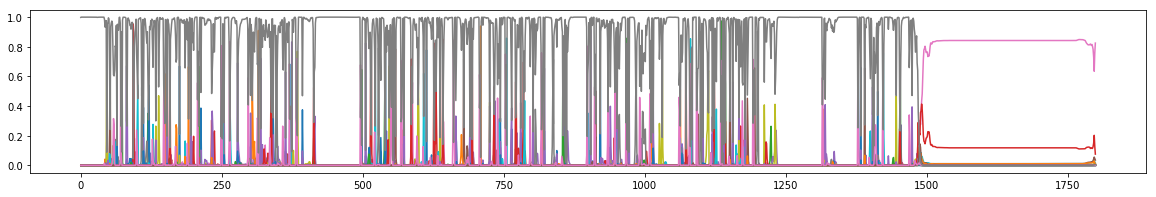

In [54]:

checking_idx = 2
plt.figure(figsize=(20,3))
plt.plot(probs[checking_idx]);


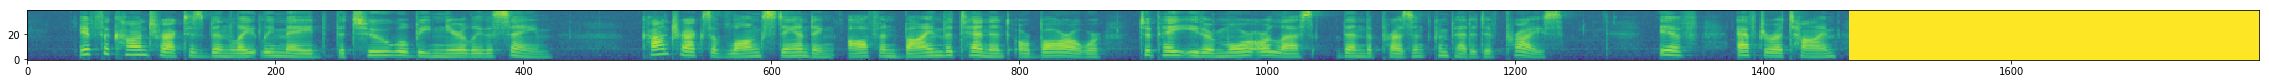

In [55]:
from matplotlib import cm

fig, ax = plt.subplots(figsize=(40,100))
mfcc_data= np.swapaxes(X_valid[checking_idx], 0 ,1)
cax = ax.imshow(mfcc_data, interpolation='nearest' , origin='lower')
# plt.figure(figsize=(10,30))
# ax.set_title('MFCC')

# plt.show()

In [56]:
alphabet = dict(zip(range(28), "abcdefghijklmnopqrstuvwxyz -"))
predicted_chars = [alphabet[idx] for idx in list(np.argmax(probs[checking_idx], axis=1)) if alphabet[idx]!="-"]
print "".join(predicted_chars)

ife coonntrakk benaly m te o lbenary tthe  sn conntrcks of  ongstannin fon  bina tenneno borrwerr o pa  o morlesbn the  rressen commpeeo  prr  aferra tmqqxxqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq


In [57]:
actual_chars = [alphabet[idx] for idx in list(y_valid[checking_idx, :label_lengths_valid[checking_idx]]) if alphabet[idx]!="-"]
print "".join(actual_chars)

if the contract has been lately made the two will be nearly the same contracts of long standing often bind the tenant or borrower to pay either more or less than the present competitive price if after a time


In [55]:
checking_id = short_ids[checking_idx]
checking_id

NameError: name 'short_ids' is not defined

In [64]:
first = probs[checking_idx]
first.shape
idxs = np.argmax(first[:,:-1], axis=1)
idxs

array([36,  2,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0,  0,  0,  3,
       36,  0,  0,  0,  0, 31,  0, 36,  0,  0,  0,  0,  0,  0,  0,  6,  2,
        2, 24, 20, 20, 13,  6,  0,  6, 23,  0,  0, 16,  2, 23,  9,  0, 10,
       10,  3, 31,  3,  0,  0, 14,  2, 25, 25, 23, 23,  0,  0,  3, 23,  3,
       22,  0,  7, 28,  6,  6, 23,  0,  9, 20,  3,  0,  0,  3,  2, 31,  9,
       20,  3,  0,  0,  6, 11, 23,  0,  0, 31,  0,  3,  0,  0,  0,  0,  0,
        0,  0, 36,  0,  0,  0,  0, 36,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2])

In [168]:
y[0]

array([32,  2, 24, 20,  0, 37, 34,  0, 15, 33,  9,  7,  6,  0, -1, -1, -1,
       -1, -1, -1], dtype=int32)

In [192]:
interpret_probs(probs[checking_idx])

NameError: name 'interpret_probs' is not defined